In [1]:
from IPython.core.display import HTML
def css_styling():
    styles = open("./custom.css", "r").read()
    return HTML(styles)
css_styling()

<img src="img/DAGA_logo.png" alt="DAGA Logo" style="width:160px; position:absolute; top:20px; right:0px;">
<img src="img/TU-lang.png" alt="TU Logo" style="width:230px; position:absolute; top:0px; right:180px;">

<h1 style="margin-top: 180px; margin-bottom: 50px; color: #A81D1E;">Getting Started with Acoular</h1>
<h3 style="margin-top: 50px; margin-bottom: 100px; color: #434343;">Art J. R. Pelling, Mikolaj Czuchaj, Gert Herold, Adam Kujawski, Oliver Lylloff, Ennes Sarradj</h2>


## What we will do

- import a microphone array geometry
- synthesize a multi-source scenario
- apply basic beamforming
- plot the results

In [2]:
# First things first
import acoular as ac

### Load microphone geometry

In [3]:
ac.MicGeom?

In [4]:
from pathlib import Path

mgpath = Path('mic') / 'array_64.xml'
with open(mgpath, 'r') as f:
    for _ in range(5):
        print(f.readline())

<?xml version="1.0" encoding="utf-8"?>									

<MicArray name="array_64">									

	<pos Name="Point 	1	" x="	0.152	" y="	0.1141	" z="	0	"/>

	<pos Name="Point 	2	" x="	0.134	" y="	0.1021	" z="	0	"/>

	<pos Name="Point 	3	" x="	0.1043	" y="	0.1036	" z="	0	"/>



In [5]:
# check coordinates
mg = ac.MicGeom( file = mgpath )
mg.pos[:,:3]

array([[0.152 , 0.134 , 0.1043],
       [0.1141, 0.1021, 0.1036],
       [0.    , 0.    , 0.    ]])

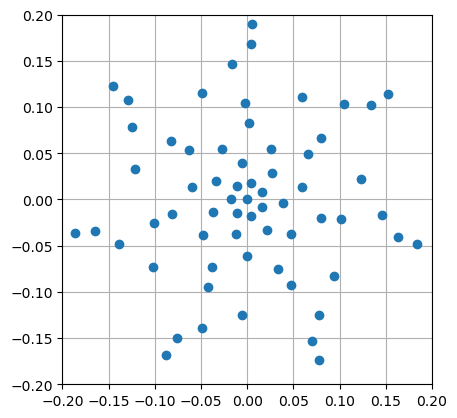

In [6]:
# visualize the microphone array
import matplotlib.pylab as plt

plt.plot( mg.pos[0], mg.pos[1], 'o' )
plt.grid()
plt.gca().set_aspect( 'equal', adjustable='box' )
plt.xlim((-0.2,0.2))
plt.ylim((-0.2,0.2));
# seven intertwined spirals

### Create a source case
- three point sources
- uncorrelated white noise

In [7]:
sfreq = 51200
duration = 1
num_samples = duration * sfreq

n1 = ac.WNoiseGenerator(sample_freq=sfreq, num_samples=num_samples, seed=1)
n2 = ac.WNoiseGenerator(sample_freq=sfreq, num_samples=num_samples, seed=2, rms=0.7)
n3 = ac.WNoiseGenerator(sample_freq=sfreq, num_samples=num_samples, seed=3, rms=0.5)

p1 = ac.PointSource(signal=n1, mics=mg, loc=(-0.1, -0.1, -0.3))
p2 = ac.PointSource(signal=n2, mics=mg, loc=(0.15, 0, -0.3))
p3 = ac.PointSource(signal=n3, mics=mg, loc=(0, 0.1, -0.3))

ts = ac.Mixer(source=p1, sources=[p2, p3])

In [8]:
isinstance(ts, ac.TimeOut)

True

We can use this object now to answer some questions about the data:
* How many channels,
* and how many samples do we have? 
* What is the sampling frequency? 

In [9]:
print( ts.num_channels, ts.num_samples, ts.sample_freq )

64 51200 51200.0


### Frequency Domain Processing
- signal processing can take place in the time domain or in the frequency domain
- need to transform the time domain data
- set blocksize and window

In [10]:
ps = ac.PowerSpectra( source=ts, block_size=128, window="Hanning" )
ps.fftfreq()

array([    0.,   400.,   800.,  1200.,  1600.,  2000.,  2400.,  2800.,
        3200.,  3600.,  4000.,  4400.,  4800.,  5200.,  5600.,  6000.,
        6400.,  6800.,  7200.,  7600.,  8000.,  8400.,  8800.,  9200.,
        9600., 10000., 10400., 10800., 11200., 11600., 12000., 12400.,
       12800., 13200., 13600., 14000., 14400., 14800., 15200., 15600.,
       16000., 16400., 16800., 17200., 17600., 18000., 18400., 18800.,
       19200., 19600., 20000., 20400., 20800., 21200., 21600., 22000.,
       22400., 22800., 23200., 23600., 24000., 24400., 24800., 25200.,
       25600.])

### Cross Spectral Matrix (CSM)
- pairwise cross spectra of all channels
- computed using Welch's method
- _lazy evaluation_ => no computations so far!

    $$\mathbf{C}(\omega) = \frac{1}{N} \sum_{n=1}^{N} \mathbf{p}(\omega) \mathbf{p}(\omega)^H \quad \text{with} \quad \mathbf{C}(\omega) \in \mathbb{C}^{M \times M}$$


In [11]:
ps.csm.shape

[('Mixer_34777131016c0ccb75d8d0cc70ce56c1_cache.h5', 1)]


(np.int64(65), np.int64(64), np.int64(64))

### Set the Focus Grid

In [12]:
ac.RectGrid?

In [13]:
rg = ac.RectGrid( x_min=-0.2, x_max=0.2,
                  y_min=-0.2, y_max=0.2,
                  z=0.3, 
                  increment=0.01 )
rg.pos

array([[-0.2 , -0.2 , -0.2 , ...,  0.2 ,  0.2 ,  0.2 ],
       [-0.2 , -0.19, -0.18, ...,  0.18,  0.19,  0.2 ],
       [ 0.3 ,  0.3 ,  0.3 , ...,  0.3 ,  0.3 ,  0.3 ]])

### Compute the Source Map
- we use _beamforming_ as our method
- combined microhpones are _steered_ to each point of the focus grid
- done by `SteeringVector` class

$$
b\left(\mathbf{x}_t\right)=\mathbf{h}^{\mathrm{H}}\left(\mathbf{x}_t\right) \mathbf{C} \mathbf{h}\left(\mathbf{x}_t\right), \quad t=1 \ldots G
$$

* Steering vector $\mathbf{h}\left(\mathbf{x}_t\right)$ is defined as

$$
h_m=\frac{1}{r_{t, 0} r_{t, m} \sum_{l=1}^M r_{t, l}^{-2}} \mathrm{e}^{-j k\left(r_{t, m}-r_{t, 0}\right)}
$$

In [14]:
st = ac.SteeringVector( grid=rg, mics=mg )

`SteeringVector` takes environmental conditions into account.
Standard `Environment` is set per default.

In [15]:
st.env?

In [16]:
st.env.c

343.0

Set up a standard (basic) beamformer. For this need two ingredients: the CSM and the steering vector.

In [17]:
bb = ac.BeamformerBase( freq_data=ps, steer=st )

__lazy evaluation__ => Still no computations!

### Compute the Beamforming Map
- compute and sum result for all frequencies in a certain range
- `num=3` for third-octave
- convert to SPL with `L_p`

In [18]:
f = 8000
num = 3

pm = bb.synthetic( f, num )
Lm = ac.L_p( pm )
Lm.shape

[('Mixer_34777131016c0ccb75d8d0cc70ce56c1_cache.h5', 2)]


(41, 41)

In [19]:
print(Lm.min(), Lm.max())

-350.0 92.31181750689572


The map has the same dimensions (41 x 41) as the grid. 
Any zero result in the map will be clipped to -350 dB level instead of -infinity.

Finally, lets plot the map!

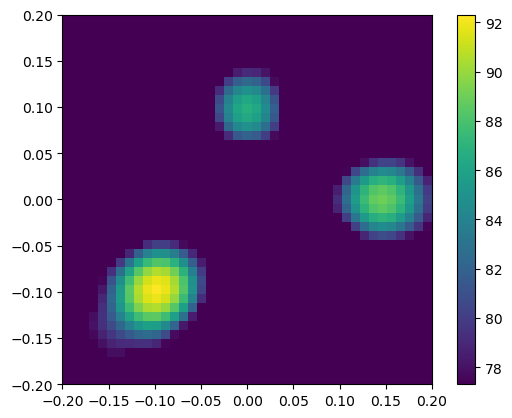

In [20]:
plt.figure()
plt.imshow( Lm.T, origin="lower", vmin=Lm.max()-15, extent=rg.extend() )
plt.colorbar();